# GLOBAL SUPERSTORE DATASET SALES ANALYSIS
By Student ID: 202410472

## 1. Task 1

#### Import required Python Libraries

In [ ]:
# pip install packages
import sys
!{sys.executable} -m pip install word2number
!{sys.executable} -m pip install geopandas
!{sys.executable} -m pip install adjustText

# import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import socket
import requests
import geopandas as gpd

from matplotlib import ticker as mtick
from tabulate import tabulate
from scipy.stats import chi2_contingency
from word2number import w2n
from adjustText import adjust_text

# Letting pandas to show max columns
pd.set_option('display.max_columns', None)

# Set the style for seaborn plots
sns.set_theme(style="whitegrid")

#### Load first 10 records

In [ ]:
# Reading CSV file and assigning into a dataframe ss_data
global_super_store_df_org = pd.read_csv('sample-superstore 2023 T3.csv')

# Copy the dataframe before processing
global_super_store_df = global_super_store_df_org.copy()

# Get the first 1000 records only for the EDA
global_super_store_df = global_super_store_df.head(n=1000)

# Set the head to 10 to retrieve the first 10 records
first_10_rows = global_super_store_df.head(n=10)
print(tabulate(first_10_rows, headers='keys', tablefmt='pretty', stralign ='right', showindex=False))

### Understanding of the dataset

#### Information of descriptive statistics

Using info() and describe() function to get the descriptive statistics

In [ ]:
# Get the metadata information about the dataset
# Grouping data types by category
numerical_columns = global_super_store_df.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = global_super_store_df.select_dtypes(include=['object']).columns
datetime_columns = global_super_store_df.select_dtypes(include=['datetime64']).columns

# Define a table width and print the header row with a dotted line
table_width = 250
print("-" * table_width)

# Print each row of the table with content and a dash line
content_list = [f"We are working with a {global_super_store_df.shape} sized dataset.", 
                    f"Numercial columns: {', '.join(numerical_columns)}",
                    f"Categorical columns: {', '.join(categorical_columns)}",
                    f"Date Time columns: {', '.join(datetime_columns)}"]

for content_row in content_list:
    print("| {:<246} |".format(content_row))
    print("-" * table_width)

# Print the table
print(tabulate(global_super_store_df.describe(), headers='keys', tablefmt='pretty', stralign ='right', showindex=False))

In [ ]:
# Print metatype information about the dataset
print(global_super_store_df.info())

#### Missing Data Analysis

In [ ]:
# Count the number of missing values in each column
missing_values_per_column = global_super_store_df.isna().sum()

# Convert the Series to a DataFrame for tabulation
missing_values_df = missing_values_per_column.to_frame().reset_index()
missing_values_df.columns = ['Column', 'Missing Values']

# Print the tabulated missing values per column
print("Number of missing values per column:\n")
print(tabulate(missing_values_df, headers='keys', tablefmt='pretty', stralign ='right', showindex=False))

# Count the total number of missing values across all columns
total_missing_values = missing_values_per_column.sum()

# Print the total number of missing values
print("\nTotal number of missing values:", total_missing_values)

The primary key of these records are a system-generated, and denoted as column: *RowID*

The datatypes of the dataset are following:
* int64(1)
* float64(2)
* object(18)

A few records of *Quantity* and *Profit* columns has the datatype of object, but it must be float64, thus needs to be cleansed or transformed.  

*Ship Date* and *Order Date* columns are represented as strings, those needs to be converted as datetime.

Once cleansed, the descriptive statistics can be applied to the numerial columns, and they are Sales, Quantity, Discount and Profit/Loss.


#### Histograms based on categorical features

In [ ]:
def plot_histogram(data, xlabel, ylabel, title): 
    
    """    
    plot_histogram generates a histogram plot for the given dataset.
    Parameters:
      data: Dataset for the histogram plot (pandas Series or any iterable).
      xlabel: Label for the x-axis.
      ylabel: Label for the y-axis.
      title: Title of the plot.
    Returns: None
    
    """
    
    plt.figure(figsize=(12, 10)) 

    bars = plt.bar(data.index, data)
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=90)
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, height, ha='center', va='bottom')
    plt.show()

In [ ]:
# Histogram for 'Ship Mode'
orders_per_segment = global_super_store_df['Ship Mode'].value_counts(ascending=True)
plot_histogram(orders_per_segment, 'Ship Mode', 'Number of Orders', 'Number of Orders per Ship Mode')

# Histogram for 'Segment'
orders_per_segment = global_super_store_df['Segment'].value_counts(ascending=True)
plot_histogram(orders_per_segment, 'Segment', 'Number of Orders', 'Number of Orders per Segment')

# Histogram for 'Category'
orders_per_category = global_super_store_df['Category'].value_counts(ascending=True)
plot_histogram(orders_per_category, 'Category', 'Number of Orders', 'Number of Orders per Category')

# Histogram for 'Sub-Category'
orders_per_sub_category = global_super_store_df['Sub-Category'].value_counts(ascending=True)
plot_histogram(orders_per_sub_category, 'Sub-Category', 'Number of Orders', 'Number of Orders per Sub-Category')

# Histogram for 'Region'
orders_per_sub_category = global_super_store_df['Region'].value_counts(ascending=True)
plot_histogram(orders_per_sub_category, 'Region', 'Number of Orders', 'Number of Orders per Region')

# Histogram for 'State'
orders_per_sub_category = global_super_store_df['State'].value_counts(ascending=True)
plot_histogram(orders_per_sub_category, 'State', 'Number of Orders', 'Number of Orders per State')

The `plot_histogram()` function can be run after the data cleansing.

## 2. Task 2

### Handling missing values in the dataset

#### Helper functions

In [ ]:
def convert_alphabetic_to_float(df, numerical_feature):
    """
    Convert alphabetic values in a DataFrame column to numbers and update the DataFrame.

    Parameters:
        df (pandas.DataFrame): The DataFrame containing the column to be processed.
        numerical_feature (str): The name of the column containing the values to be converted.

    Returns:
        None. The function modifies the input DataFrame in place.
    """
    
    # Create alphabetic filter using regex
    alphabetic_filter = df[numerical_feature].str.contains(r'^[a-zA-Z]+$', na=False)
    alphabetic_filtered_df = df.loc[alphabetic_filter]

    # Convert alphabetic values to numbers using w2n.word_to_num library
    alphabetic_filtered_df.loc[:, numerical_feature] = alphabetic_filtered_df[numerical_feature].apply(w2n.word_to_num)

    # Update the original DataFrame with the filtered results
    df.update(alphabetic_filtered_df)

    # Convert the column to float
    df[numerical_feature] = df[numerical_feature].astype(float)

In [ ]:
def is_internet_connected():
    """
    Check if the machine is connected to the internet by attempting to connect to Google's DNS server.
    The function is used to conect to post code API to retrieve City and State
    Returns:
        bool: True if the machine is connected to the internet, False otherwise.
    """
    try:
        # Attempt to connect to Google's DNS server
        socket.create_connection(("8.8.8.8", 53), timeout=3)
        return True
    except OSError:
        pass
    return False

In [ ]:
def get_city_from_postal_code(postal_code):
    """
    get_city_from_postal_code retrieves the city name from postal code using zippopotam API.
    Parameters:
        postal_code: Postal code for the city.
    Returns:
        str or None: City name corresponding to the given postal code, or None if postal_code is empty or invalid.
    """
    if not is_internet_connected():
        return None

    if postal_code == '':
        return None

    url = f"http://api.zippopotam.us/us/{postal_code}"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        city = data['places'][0]['place name']
        return city
    else:
        return None

In [ ]:
def get_state_from_postal_code(postal_code):
    """
    get_state_from_postal_code retrieves the state name from postal code using zippopotam API.
    Parameters:
        postal_code: Postal code for the state.
    Returns:
        str or None: State name corresponding to the given postal code, or None if postal_code is empty or invalid.
    """

    if not is_internet_connected():
        return None

    if postal_code == '':
        return None

    url = f"http://api.zippopotam.us/us/{postal_code}"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        state = data['places'][0]['state']
        return state
    else:
        return None

In [ ]:
def format_date_in_yyyymmdd(date_str):
    """
    Formats a date string to the format 'yyyy-mm-dd'.

    Parameters:
    - date_str (str or pd.NA): A string representing a date.

    Returns:
    - str or pd.NA: The standardized date string in 'yyyy-mm-dd' format, or pd.NA if input is blank or NaN.
    """
    if pd.notna(date_str) and date_str.strip():  # Check if date is not blank or NaN
        try:
            # Attempt to parse as yyyy-mm-dd with dayfirst=False
            return pd.to_datetime(date_str, dayfirst=False, errors='coerce').strftime('%Y-%m-%d')
        except ValueError:
            # If parsing fails, attempt to parse as dd-mm-yyyy
            return pd.to_datetime(date_str, format='%d-%m-%Y', errors='coerce').strftime('%Y-%m-%d')
    else:
        return date_str  # Return the original blank or NaN value

#### Dropping unwanted columns

In [ ]:
# Columns to drop
columns_to_drop = ['Row ID', 'Order ID', 'Customer ID', 'Product ID', 'Product Name']

# Row ID is not needed for the analysis, hence dropping the column
global_super_store_df.drop(columns=columns_to_drop, inplace=True)

#### Replacing faulty values

In [ ]:
# Removing "?" from Quantity column
global_super_store_df['Quantity'] = global_super_store_df['Quantity'].str.replace('?', '')

# Removing """ from profit column
global_super_store_df['Profit'] = global_super_store_df['Profit'].str.replace('"', '')

# Removing """ from Postal Code column
global_super_store_df['Postal Code'] = global_super_store_df['Postal Code'].str.replace('"', '')

# Make all records as Country = United States
global_super_store_df['Country'] = 'United States'

# Correcting spelling mistakes on Category column
global_super_store_df['Category'] = global_super_store_df['Category'].replace('Frnture', 'Furniture')

# Datafix on Category based on subcategories
# Apply the condition element-wise
condition = (global_super_store_df['Category'] == 'NO_CATEGORY') & \
            (global_super_store_df['Sub-Category'].isin(['Binders', 'Storage']))

# Update 'Category' where the condition is True
global_super_store_df.loc[condition, 'Category'] = 'Office Supplies'

# Update empty and wrong records on Segment Column
global_super_store_df['Segment'] = global_super_store_df['Segment'].replace('%', 'NO_SEGMENT')

# Cleanse the Regions
central_regions_to_replace = ['Centrl', 'Cntral']
east_regions_to_replace = ['Est']
south_regions_to_replace = ['Southh']

global_super_store_df['Region'] = global_super_store_df['Region'].replace(central_regions_to_replace, 'Central')
global_super_store_df['Region'] = global_super_store_df['Region'].replace(east_regions_to_replace, 'East')
global_super_store_df['Region'] = global_super_store_df['Region'].replace(south_regions_to_replace, 'South')

# Cleanse the Order Date column
global_super_store_df['Order Date'] = global_super_store_df['Order Date'].str.replace('$April', '')

# Cleanse the Customer Name column
global_super_store_df['Customer Name'] = global_super_store_df['Customer Name'].str.replace('10', 'NONE')

#### Filling empty values with default values

In [ ]:
# Filling values on empty Customer Name records
global_super_store_df['Customer Name'] = global_super_store_df['Customer Name'].fillna('NO_CUSTOMER_NAME')

# Assuming zero values for NaN on Profit
global_super_store_df['Profit'] = global_super_store_df['Profit'].fillna(0.00)

# Filling values on empty Category and Sub-Category records
global_super_store_df['Category'] = global_super_store_df['Category'].fillna('NO_CATEGORY')
global_super_store_df['Sub-Category'] = global_super_store_df['Sub-Category'].fillna('NO_SUB_CATEGORY')

# Filling Quantity as 1 as sold quantity cannot be zero
global_super_store_df['Quantity'] = global_super_store_df['Quantity'].fillna(1.00)

# Filling Discount as 0
global_super_store_df['Discount'] = global_super_store_df['Discount'].fillna(0.00)

# Filling Sales as 0
global_super_store_df['Sales'] = global_super_store_df['Sales'].fillna(0.00)

# Filling values on empty Ship Mode records
global_super_store_df['Ship Mode'] = global_super_store_df['Ship Mode'].fillna('NO_SHIP_MODE')

# Filling values on empty Postal Code records
global_super_store_df['Postal Code'] = global_super_store_df['Postal Code'].fillna('NO_POSTAL_CODE')

# Filling values on empty Region records
global_super_store_df['Region'] = global_super_store_df['Region'].fillna('NO_REGION')

# Filling values on empty Segment records
global_super_store_df['Segment'] = global_super_store_df['Segment'].fillna('NO_SEGMENT')

#### Applying helper functions to fill the data

In [ ]:
# Filter the empty state rows
state_filtered_na = global_super_store_df.loc[pd.isna(global_super_store_df['State'])]
state_filtered_na

# Apply the function to fill the missing value via API
global_super_store_df.loc[pd.isna(global_super_store_df['State']), 'State'] = state_filtered_na['Postal Code'].apply(get_state_from_postal_code)

In [ ]:
# Filter the empty city rows
city_filtered_na = global_super_store_df.loc[pd.isna(global_super_store_df['City'])]
city_filtered_na

# Apply the function to fill the missing value via API
global_super_store_df.loc[pd.isna(global_super_store_df['City']), 'City'] = city_filtered_na['Postal Code'].apply(get_city_from_postal_code)

In [ ]:
# Call the function to convert the the Quantity and Profit columns which has alphabetic values and convert them to float
convert_alphabetic_to_float(global_super_store_df, 'Quantity')
convert_alphabetic_to_float(global_super_store_df, 'Profit')

#### Order Date / Ship Date fixes

In [ ]:
# Get the all the records out of that filter to fix
date_fix_condition = (~global_super_store_df['Ship Date'].isna()) & \
                            (~global_super_store_df['Order Date'].isna())

# Standardize Order Date column
global_super_store_df.loc[date_fix_condition, 'Order Date'] = global_super_store_df.loc[date_fix_condition, 'Order Date'].apply(format_date_in_yyyymmdd)

# Standardize Ship Date column
global_super_store_df.loc[date_fix_condition, 'Ship Date'] = global_super_store_df.loc[date_fix_condition, 'Ship Date'].apply(format_date_in_yyyymmdd)

# Swap Order Date and Ship Date if necessary
for index, row in global_super_store_df.iterrows():
    order_date = pd.to_datetime(row['Order Date'], errors='coerce')  # Coerce errors to NaT for comparison
    ship_date = pd.to_datetime(row['Ship Date'], errors='coerce')  # Coerce errors to NaT for comparison
    
    if not pd.isna(order_date) and not pd.isna(ship_date) and order_date > ship_date:
        global_super_store_df.at[index, 'Order Date'], global_super_store_df.at[index, 'Ship Date'] = row['Ship Date'], row['Order Date']

In [ ]:
# Convert columns to datetime64 dtype
global_super_store_df['Order Date'] = pd.to_datetime(global_super_store_df['Order Date'], format='mixed')
global_super_store_df['Ship Date'] = pd.to_datetime(global_super_store_df['Ship Date'], format='mixed')

# Filling 01/01/1970 date as a NO_DATA_DATE date
global_super_store_df['Order Date'] = global_super_store_df['Order Date'].fillna('1970/01/01')
global_super_store_df['Ship Date'] = global_super_store_df['Ship Date'].fillna('1970/01/01')

#### New columns to Analyze

After cleansing the data, the following columns have been added to perform EDA and visualizations.

| Column Name   | Data Type | Description                                                                   |
| ------------  | --------- |-------------------------------------------------------------------------------|
| Loss          | float64   | Negative losss will be marked as loss                                       |   
| Shipment Days | float64   | Calculate the days between Order Date and Shipped Date                        |                                         
| Order Year    | int32     | Extracted year from Order Date to plot the sales/loss trends                |
| Ship Year     | int32     | Extracted year from Ship Date to plot the sales/loss trends                 |                       
| Gender        | object    | Experimenting to guess the gender of the customer to perform gender analysis  |                                      

In [ ]:
# New column Shipment Days
global_super_store_df['Shipment Days'] = (global_super_store_df['Ship Date'] - global_super_store_df['Order Date']).dt.days

# New columns: Order Year and Ship Year. extract year from 'Order Date' and 'Ship Date' columns
global_super_store_df['Order Year'] = pd.DatetimeIndex(global_super_store_df['Order Date']).year
global_super_store_df['Ship Year'] = pd.DatetimeIndex(global_super_store_df['Ship Date']).year

# Fill NaN values with 0 (assuming missing years should be represented as 0)
global_super_store_df[['Order Year', 'Ship Year']] = global_super_store_df[['Order Year', 'Ship Year']].fillna(0)

# Convert year columns to integer dtype
global_super_store_df[['Order Year', 'Ship Year']] = global_super_store_df[['Order Year', 'Ship Year']].astype(int)

# New column 'Loss' where loss is negative
global_super_store_df['Loss'] = global_super_store_df['Profit'].apply(lambda x: -x if x < 0 else 0)

#### Removing the filler values

In [ ]:
def filter_out_filler_values_count(df, column, filler_value):
    """
    Filters out rows from the DataFrame where the value in the specified column matches the specified filler value and returns the count of filtered values.

    Parameters:
        df (DataFrame): The pandas DataFrame containing the data.
        column (str): The name of the column to filter on.
        filler_value: The value to match in the specified column for filtering.

    Returns:
        int: The count of filtered values.
    """
    filtered_count = len(df[df[column] == filler_value])
    return filtered_count

In [ ]:
def remove_filler_values_on_df(df, key_column, key_value):
    """
    Filters out rows from the DataFrame where the value in the key column matches the specified key value and updates the original DataFrame.

    Parameters:
        df (DataFrame): The pandas DataFrame containing the data.
        key_column (str): The name of the column to filter on.
        key_value: The value to match in the key column for filtering.

    Returns:
        None
    """
    # Filter out rows matching the condition
    df.drop(df[df[key_column] == key_value].index, inplace=True)

In [ ]:
# Define the dictionary of column names and filler values
filter_filler_values_dict = {
    'Category': 'NO_CATEGORY',
    'Sub-Category': 'NO_SUB_CATEGORY',
    'Segment': 'NO_SEGMENT',
    'Ship Mode': 'NO_SHIP_MODE',
    'Customer Name': 'NO_CUSTOMER_NAME',
    'Postal Code': 'NO_POSTAL_CODE',
    'Region': 'NO_REGION',
    'Order Date': '1970/01/01',
    'Ship Date': '1970/01/01'
}

In [ ]:
# Initialize a list to store the filtered count results
filter_count_results = []

# Iterate over the dictionary filter_filler_values_dict items and apply the filtering
for column, filler_value in filter_filler_values_dict.items():
    filtered_count = filter_out_filler_values_count(global_super_store_df, column, filler_value)
    filter_count_results.append([column, filler_value, filtered_count])

# Print the results as a table
print(tabulate(filter_count_results, headers=['Column', 'Filler Value', 'Filtered Count'], tablefmt='pretty', stralign ='right', showindex=False))

The filler values are pretty small when compared to the dataset (1000 rows).
These records are removed from the `global_super_store_df` dataframe.

In [ ]:
# Iterate over the dictionary items and apply the filtering
for column, filler_value in filter_filler_values_dict.items():
    remove_filler_values_on_df(global_super_store_df, column, filler_value)

#### Plotting histograms after cleansing data

In [ ]:
# Histogram for 'Ship Mode'
orders_per_segment = global_super_store_df['Ship Mode'].value_counts(ascending=True)
plot_histogram(orders_per_segment, 'Ship Mode', 'Number of Orders', 'Number of Orders per Ship Mode')

# Histogram for 'Segment'
orders_per_segment = global_super_store_df['Segment'].value_counts(ascending=True)
plot_histogram(orders_per_segment, 'Segment', 'Number of Orders', 'Number of Orders per Segment')

# Histogram for 'Category'
orders_per_category = global_super_store_df['Category'].value_counts(ascending=True)
plot_histogram(orders_per_category, 'Category', 'Number of Orders', 'Number of Orders per Category')

# Histogram for 'Sub-Category'
orders_per_sub_category = global_super_store_df['Sub-Category'].value_counts(ascending=True)
plot_histogram(orders_per_sub_category, 'Sub-Category', 'Number of Orders', 'Number of Orders per Sub-Category')

# Histogram for 'Region'
orders_per_sub_category = global_super_store_df['Region'].value_counts(ascending=True)
plot_histogram(orders_per_sub_category, 'Region', 'Number of Orders', 'Number of Orders per Region')

# Histogram for 'State'
orders_per_sub_category = global_super_store_df['State'].value_counts(ascending=True)
plot_histogram(orders_per_sub_category, 'State', 'Number of Orders', 'Number of Orders per State')

### Descriptive statistics

In [ ]:
# Descriptive Statistics
descriptive_stats = global_super_store_df.describe().round(2)

# Generate descriptive statistics
print(tabulate(descriptive_stats, headers='keys', tablefmt='pretty', stralign ='right', showindex=True))

In [ ]:
# Calculate the number of missing values for each column
missing_values = global_super_store_df.isnull().sum().to_frame(name='Missing Value Count')

# Display the missing values using tabulate
print(tabulate(missing_values, headers='keys', tablefmt='pretty', stralign='right', showindex=True))

### Grouping of data

#### Helper Functions

In [ ]:
def print_sales_loss_by_feature(df, feature_column, category_column):
    """
    print_sales_loss_by_feature, prints total sales/loss by category in a tabular format.

    Parameters:
    - df (DataFrame): The DataFrame containing the sales data.
    - sales_column (str): The name of the column containing sales data.
    - sales_category_column (str): The name of the column to group by.

    Returns:
    - None
    """
    # Group total sales by category
    sales_category = df.groupby(category_column)[feature_column].sum().round(4).reset_index().sort_values(by=feature_column, ascending=False)
    
    # Convert the grouped DataFrame to a list of lists
    sales_category_list = sales_category.values.tolist()

    # Print the table using tabulate
    print(tabulate(sales_category_list, headers=[category_column, f'Total {feature_column}'], tablefmt='pretty', stralign ='right'))

#### Grouping Sales/Losses based on Categories

In [1548]:
# group total sales by category from the highest sale.
print_sales_loss_by_feature(global_super_store_df.round(2), 'Sales', 'Category')

+-----------------+-------------+
|        Category | Total Sales |
+-----------------+-------------+
|       Furniture |   116557.31 |
| Office Supplies |    33760.19 |
|      Technology |    31177.37 |
+-----------------+-------------+


In [1549]:
# group total loss by category from the highest sale.
print_sales_loss_by_feature(global_super_store_df.round(2), 'Loss', 'Category')

+-----------------+------------+
|        Category | Total Loss |
+-----------------+------------+
|       Furniture |   22084.51 |
| Office Supplies |   13646.38 |
|      Technology |    6180.55 |
+-----------------+------------+


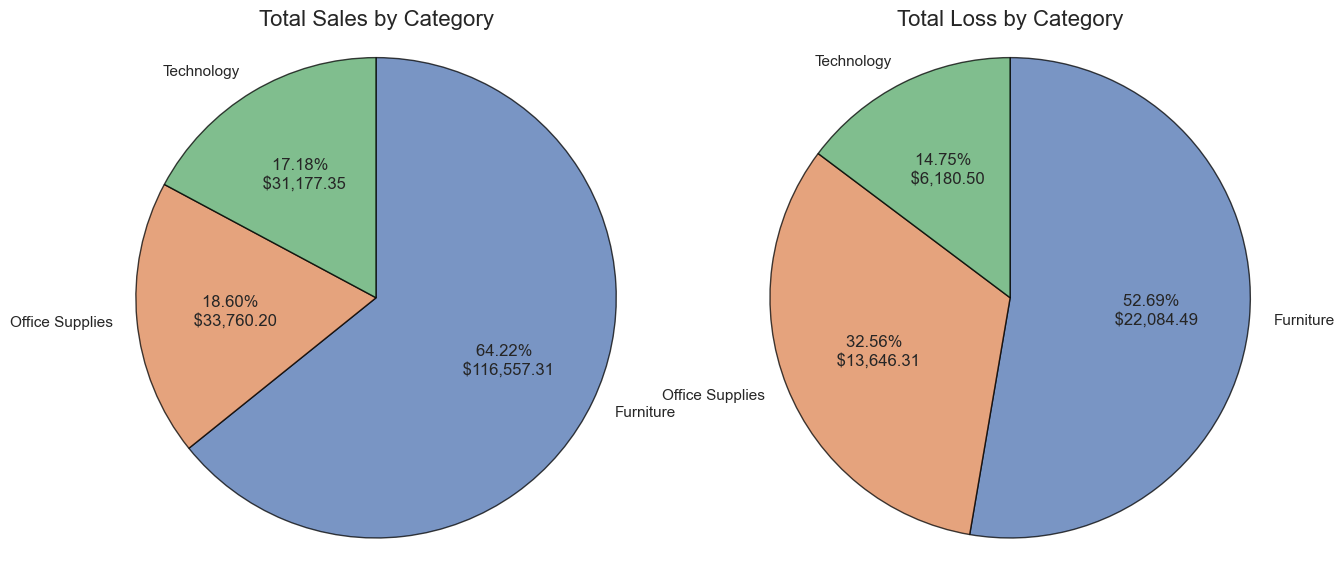

In [1550]:
# group total sales by category, only considering sales
sales_category = global_super_store_df.groupby('Category')['Sales'].sum()

# group total loss by category, only considering losses
loss_category = global_super_store_df.groupby('Category')['Loss'].sum()

# figure size
plt.figure(figsize=(15,10));

# left total sales pie chart
plt.subplot(1,2,1); # 1 row, 2 columns, the 1st plot.
plt.pie(sales_category.values, labels=sales_category.index, startangle=90, counterclock=False,
        autopct=lambda p:f'{p:,.2f}% \n ${p * np.sum(sales_category.values) / 100 :,.2f}', 
        wedgeprops={'linewidth': 1, 'edgecolor':'black', 'alpha':0.75});
plt.axis('square');
plt.title('Total Sales by Category',  fontdict={'fontsize':16});

# right total loss pie chart
plt.subplot(1,2,2); # 1 row, 2 columns, the 2nd plot
plt.pie(loss_category.values, labels=loss_category.index, startangle=90, counterclock=False,
        autopct=lambda p:f'{p:,.2f}% \n ${p * np.sum(loss_category.values) / 100 :,.2f}',
        wedgeprops={'linewidth': 1, 'edgecolor':'black', 'alpha':0.75});
plt.axis('square');
plt.title('Total Loss by Category', fontdict={'fontsize':16});

 > _Total Sales on Categories_

1. Furniture at ~53% 
2. Technology at ~27%
3. Office Supplies at ~20%



 > _Total Losses on Categories_

1. Furniture at ~39%
2. Office Supplies at ~34%
3. Technology at ~26%


#### Grouping Sales/Losses based on Sub-Categories

In [1552]:
# group total sales by sub-category from the highest sale.
print_sales_loss_by_feature(global_super_store_df.round(2), 'Sales', 'Sub-Category')

+--------------+-------------+
| Sub-Category | Total Sales |
+--------------+-------------+
|       Chairs |    51548.39 |
|       Tables |    37126.64 |
|      Storage |    23097.64 |
|       Phones |    22055.87 |
|    Bookcases |    20645.12 |
|  Furnishings |     7237.16 |
|      Binders |     6700.05 |
|     Machines |     4653.15 |
|  Accessories |     4468.35 |
|     Supplies |      2853.4 |
|   Appliances |      1109.1 |
+--------------+-------------+


In [1553]:
# group total loss by sub-category from the highest loss.
print_sales_loss_by_feature(global_super_store_df.round(2), 'Loss', 'Sub-Category')

+--------------+------------+
| Sub-Category | Total Loss |
+--------------+------------+
|       Tables |     8874.7 |
|       Chairs |    6862.93 |
|      Binders |    6351.03 |
|       Phones |     4578.3 |
|      Storage |    4046.11 |
|    Bookcases |    3559.79 |
|  Furnishings |    2787.09 |
|   Appliances |    2677.25 |
|     Machines |    1061.92 |
|     Supplies |     571.99 |
|  Accessories |     540.33 |
+--------------+------------+


In [1554]:
#Grouping the data on category and it's respective sub-categories. Calculating the loss margin.
sales_per_cat_subcat = global_super_store_df.groupby(['Category', 'Sub-Category'], as_index=False)[['Sales', 'Loss']].sum()
sales_per_cat_subcat['Loss %'] = (sales_per_cat_subcat['Loss'] / sales_per_cat_subcat['Sales']) * 100

#Sorting the dataframe based on loss margin
sales_per_cat_subcat = sales_per_cat_subcat.sort_values(by=['Loss %'], ascending=False)
print(tabulate(sales_per_cat_subcat.round(2), headers='keys', tablefmt='pretty', stralign ='right', showindex=False))

+-----------------+--------------+----------+---------+--------+
|        Category | Sub-Category |    Sales |    Loss | Loss % |
+-----------------+--------------+----------+---------+--------+
| Office Supplies |   Appliances |  1109.13 | 2677.24 | 241.38 |
| Office Supplies |      Binders |  6700.04 | 6350.99 |  94.79 |
|       Furniture |  Furnishings |  7237.19 | 2787.11 |  38.51 |
|       Furniture |       Tables | 37126.62 | 8874.71 |   23.9 |
|      Technology |     Machines |  4653.17 |  1061.9 |  22.82 |
|      Technology |       Phones | 22055.85 | 4578.27 |  20.76 |
| Office Supplies |     Supplies |  2853.39 |  571.98 |  20.05 |
| Office Supplies |      Storage | 23097.64 |  4046.1 |  17.52 |
|       Furniture |    Bookcases | 20645.12 | 3559.75 |  17.24 |
|       Furniture |       Chairs | 51548.37 | 6862.92 |  13.31 |
|      Technology |  Accessories |  4468.33 |  540.32 |  12.09 |
+-----------------+--------------+----------+---------+--------+


#### Grouping Sales/Losses based on Region

In [1547]:
# group total sales by regions from the highest sale.
sales_by_segment = global_super_store_df.groupby(['Region'], as_index=False)[['Sales', 'Loss']].sum().sort_values(by='Sales', ascending=False)
sales_by_segment['Sales %'] = (sales_by_segment['Sales'] / global_super_store_df['Sales'].sum()) * 100
sales_by_segment['Loss %'] = (sales_by_segment['Loss'] / sales_by_segment['Sales']) * 100

# Convert numerical values to strings with commas for thousands separators and round to 2 decimal places
for numerical_column in sales_by_segment.select_dtypes(include=['int64', 'float64']).columns:
    sales_by_segment[numerical_column] = sales_by_segment[numerical_column].apply(lambda x: '{:,.2f}'.format(x))

# List of total sales by states
print(tabulate(sales_by_segment.round(2), headers='keys', tablefmt='pretty', stralign ='right', showindex=False))

+---------+-----------+-----------+---------+--------+
|  Region |     Sales |      Loss | Sales % | Loss % |
+---------+-----------+-----------+---------+--------+
|    East | 66,859.67 | 14,786.98 |   36.84 |  22.12 |
| Central | 58,835.42 | 16,243.24 |   32.42 |  27.61 |
|    West | 35,808.49 |  6,128.74 |   19.73 |  17.12 |
|   South | 19,991.27 |  4,752.34 |   11.01 |  23.77 |
+---------+-----------+-----------+---------+--------+


#### Grouping Sales/Losses based on States

In [ ]:
# group total sales by states from the highest sale.
sales_by_states = global_super_store_df.groupby(['State'], as_index=False)[['Sales', 'Loss']].sum().sort_values(by='Sales', ascending=False)
sales_by_states['Sales %'] = (sales_by_states['Sales'] / global_super_store_df['Sales'].sum()) * 100
sales_by_states['Loss %'] = (sales_by_states['Loss'] / sales_by_states['Sales']) * 100

# Convert numerical values to strings with commas for thousands separators and round to 2 decimal places
for numerical_column in sales_by_states.select_dtypes(include=['int64', 'float64']).columns:
    sales_by_states[numerical_column] = sales_by_states[numerical_column].apply(lambda x: '{:,.2f}'.format(x))

# List of total sales by states
print(tabulate(sales_by_states.round(2), headers='keys', tablefmt='pretty', stralign ='right', showindex=False))

**State made the highest sales %:** Texas \
**State made the lowest sales %:** Connecticut

#### Grouping Sales/Losses based on Segment

In [ ]:
# group total sales by segments from the highest sale.
sales_by_segment = global_super_store_df.groupby(['Segment'], as_index=False)[['Sales', 'Loss']].sum().sort_values(by='Sales', ascending=False)
sales_by_segment['Sales %'] = (sales_by_segment['Sales'] / global_super_store_df['Sales'].sum()) * 100
sales_by_segment['Loss %'] = (sales_by_segment['Loss'] / sales_by_segment['Sales']) * 100

# Convert numerical values to strings with commas for thousands separators and round to 2 decimal places
for numerical_column in sales_by_segment.select_dtypes(include=['int64', 'float64']).columns:
    sales_by_segment[numerical_column] = sales_by_segment[numerical_column].apply(lambda x: '{:,.2f}'.format(x))

# List of total sales by states
print(tabulate(sales_by_segment.round(2), headers='keys', tablefmt='pretty', stralign ='right', showindex=False))

**Consumer** Segment has 50% of Sales share, followed by **Corporate** and **Home Office**.

#### Grouping Sales/Losses based on Shipping Mode

In [1551]:
# group total sales by segments from the highest sale.
sales_by_ship_mode = global_super_store_df.groupby(['Ship Mode'], as_index=False)[['Sales', 'Loss']].sum().sort_values(by='Sales', ascending=False)
sales_by_ship_mode['Sales %'] = (sales_by_ship_mode['Sales'] / global_super_store_df['Sales'].sum()) * 100
sales_by_ship_mode['Loss %'] = (sales_by_ship_mode['Loss'] / sales_by_ship_mode['Sales']) * 100

# Convert numerical values to strings with commas for thousands separators and round to 2 decimal places
for numerical_column in sales_by_segment.select_dtypes(include=['int64', 'float64']).columns:
    sales_by_ship_mode[numerical_column] = sales_by_ship_mode[numerical_column].apply(lambda x: '{:,.2f}'.format(x))

# List of total sales by states
print(tabulate(sales_by_ship_mode.round(2), headers='keys', tablefmt='pretty', stralign ='right', showindex=False))

+----------------+-----------+----------+---------+--------+
|      Ship Mode |     Sales |     Loss | Sales % | Loss % |
+----------------+-----------+----------+---------+--------+
| Standard Class | 113416.74 | 26048.73 |   62.49 |  22.97 |
|    First Class |  32467.32 |  7277.31 |   17.89 |  22.41 |
|   Second Class |   28101.2 |  6892.23 |   15.48 |  24.53 |
|       Same Day |    7509.6 |  1693.03 |    4.14 |  22.54 |
+----------------+-----------+----------+---------+--------+


**Standard** shipping method is preferred as the sales percentage is nearly 64%, followed by **Second Class** and **First Class**. 
**Same Day** is not an economical option, so only preferred by 6% of the orders.

In [ ]:
# Filter the filler date 01/01/1970 - the default NO_DATA date
global_super_store_df_date_filtered = global_super_store_df[(global_super_store_df['Order Date'] != pd.to_datetime('01/01/1970')) & (global_super_store_df['Ship Date'] != pd.to_datetime('01/01/1970'))].groupby('Ship Mode')['Shipment Days'].mean()
grouped_data = global_super_store_df_date_filtered.round(3).reset_index().values.tolist()

print(tabulate(grouped_data, headers=['Ship Mode', 'Average Shipped in Days'], tablefmt='pretty', stralign ='right', showindex=False))

* **Standard Class** shipping method takes ~5 days to ship from the order date.
* **First Class** and **Second Class** are between 2-3 days. 
* **Same Day** is as promised, the orders are shipped with a day.

In conclusion, **Second Class** ship mode is the best value for money, being economical than **First Class** and faster than **Standard Class**.

### Univariate analysis and visualisation

#### Histograms

In [ ]:
def plot_histogram_density(df, column, xlim=None):
    """
    Plot histogram with density plot for a specified column in the DataFrame.

    Parameters:
    df (DataFrame): Input DataFrame.
    column (str): Name of the column to plot.
    xlim (tuple): Tuple containing the lower and upper limits of the x-axis.

    Returns:
    None
    """
    # Create subplots for each column
    fig, ax = plt.subplots(figsize=(12, 10))

    # Plot histogram with density plot
    sns.histplot(df[column], kde=True, ax=ax)
    ax.set_title(f'Distribution of {column}')

    # Set x-axis limits if specified
    if xlim:
        plt.xlim(xlim)

    # Show the plot
    plt.show()

In [ ]:
plot_histogram_density(global_super_store_df, 'Sales', xlim=(0, 2500))
plot_histogram_density(global_super_store_df, 'Loss', xlim=(0, 2500))
plot_histogram_density(global_super_store_df, 'Quantity')
plot_histogram_density(global_super_store_df, 'Discount')

#### Probability Density Function / Cumulative Density Function

In [ ]:
# Normalize all columns in the DataFrame
numerical_columns = global_super_store_df.select_dtypes(include=['int64', 'float64']).columns
normalized_df = (global_super_store_df[numerical_columns] - global_super_store_df[numerical_columns].mean()) / global_super_store_df[numerical_columns].std()

# Create subplots for each column
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot PDF and CDF for Sales
sns.kdeplot(normalized_df['Sales'], cumulative=False, ax=axes[0, 0], color='blue', label='PDF', common_norm=True)
sns.kdeplot(normalized_df['Sales'], cumulative=True, ax=axes[0, 0], color='red', label='CDF')
axes[0, 0].set_title('PDF and CDF for Sales')
axes[0, 0].axvline(x=0, linestyle='--', color='gray')  # Add a dotted line at x = 0
axes[0, 0].set_xlim(-3, 3)  # Set custom x-axis limits

# Plot PDF and CDF for Quantity
sns.kdeplot(normalized_df['Quantity'], cumulative=False, ax=axes[0, 1], color='blue', label='PDF', common_norm=True)
sns.kdeplot(normalized_df['Quantity'], cumulative=True, ax=axes[0, 1], color='red', label='CDF')
axes[0, 1].set_title('PDF and CDF for Quantity')
axes[0, 1].axvline(x=0, linestyle='--', color='gray')  # Add a dotted line at x = 0
axes[0, 1].set_xlim(-3, 3)  # Set custom x-axis limits

# Plot PDF and CDF for Discount
sns.kdeplot(normalized_df['Discount'], cumulative=False, ax=axes[1, 0], color='blue', label='PDF', common_norm=True)
sns.kdeplot(normalized_df['Discount'], cumulative=True, ax=axes[1, 0], color='red', label='CDF')
axes[1, 0].set_title('PDF and CDF for Discount')
axes[1, 0].axvline(x=0, linestyle='--', color='gray')  # Add a dotted line at x = 0
axes[1, 0].set_xlim(-3, 3)  # Set custom x-axis limits

# Plot PDF and CDF for Loss
sns.kdeplot(normalized_df['Loss'], cumulative=False, ax=axes[1, 1], color='blue', label='PDF', common_norm=True)
sns.kdeplot(normalized_df['Loss'], cumulative=True, ax=axes[1, 1], color='red', label='CDF')
axes[1, 1].set_title('PDF and CDF for Loss')
axes[1, 1].axvline(x=0, linestyle='--', color='gray')  # Add a dotted line at x = 0
axes[1, 1].set_xlim(-3, 3)  # Set custom x-axis limits

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

In [ ]:
# Calculate skewness for each column
skewness = normalized_df[['Sales', 'Loss', 'Quantity', 'Discount']].skew()

print(tabulate(skewness.to_frame().round(4), headers=['Numercial Features', 'Skewness'], tablefmt='pretty', stralign ='right', showindex=True))

#### Trends

In [ ]:
def plot_trend(df, numerical_column, display_dollar_sign=False):
    """
    plot_trend, generates a trend plot for a specified column in a DataFrame, showing the total value of the column over the years.

    Parameters:
    - df (DataFrame): The DataFrame containing the data.
    - numerical_column (str): The name of the column for which the trend plot is to be generated.
    - display_dollar_sign (bool): Whether to display y-axis values with a dollar sign ($) prefix. Default is False.

    Returns:
    None
    """
    
    # Group by 'Order Year' and calculate the sum of the specified column
    trend_data = df.groupby(['Order Year'])[numerical_column].sum()
 
    # Create the plot
    fig, ax = plt.subplots(figsize=(15,10))

    # Plot the bar plot
    bars = ax.bar(x=trend_data.index, height=trend_data.values, color='teal')

    # Annotate each bar with its value
    for bar in bars:
        height = bar.get_height()
        if display_dollar_sign:
            ax.annotate('$ {:,.2f}'.format(height),
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')
        else:
            ax.annotate('{:,.2f}'.format(height),
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    # Plot the line plot
    ax.plot(trend_data.index, trend_data.values, color='orange')

    # Turn off scientific notation for y-axis
    ax.yaxis.get_major_formatter().set_scientific(False)

    # Set title and labels
    plt.title(f'{numerical_column} trend over the years', fontsize=18)
    plt.ylabel(f'Total {numerical_column}', fontsize=14)
    plt.xlabel('Order Year', fontsize=14)

    # Convert 'Order Year' column to a list of integers
    years = trend_data.index.tolist()

    # Set x-ticks to only include specific years
    plt.xticks(years, rotation=45)

    # Add gridlines
    plt.grid(axis='x')

    # Show the plot
    plt.show()


In [ ]:
# Call the function for sales
plot_trend(global_super_store_df, 'Sales', display_dollar_sign=True)

# Call the function for quantities
plot_trend(global_super_store_df, 'Quantity', display_dollar_sign=False)

# Call the function for loss
plot_trend(global_super_store_df, 'Loss', display_dollar_sign=True)

# Call the function for discounts
plot_trend(global_super_store_df, 'Discount', display_dollar_sign=True)


### Outlier Treatment

##### Interquartile Range (IQR) Method

In [ ]:
def detect_plot_outliers_iqr(df, numerical_feature):
    """
    Plots a boxplot for the specified numerical feature and identifies outliers based on the interquartile range (IQR).

    Parameters:
        df (DataFrame): The pandas DataFrame containing the data.
        numerical_feature (str): The name of the numerical feature to analyze.

    Returns:
        None
    """

    q1 = df[numerical_feature].quantile(0.25)
    q3 = df[numerical_feature].quantile(0.75)

    iqr = q3 - q1
    lower_limit = q1 - 1.5 * iqr
    upper_limit = q3 + 1.5 * iqr

    outliers_df = df[(df[numerical_feature] < lower_limit)|(df[numerical_feature] > upper_limit)]
    print(f"Outlier numerical feature: {numerical_feature}, Outlier Count: {outliers_df[numerical_feature].count()}")
    
    numerical_column = df[numerical_feature]
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=numerical_column)
    plt.title(f'Boxplot of Outliers for {numerical_feature}')
    plt.show()

In [ ]:
detect_plot_outliers_iqr(global_super_store_df, 'Sales')
detect_plot_outliers_iqr(global_super_store_df, 'Quantity')
detect_plot_outliers_iqr(global_super_store_df, 'Discount')
detect_plot_outliers_iqr(global_super_store_df, 'Loss')
detect_plot_outliers_iqr(global_super_store_df, 'Shipment Days')

##### Z-Score Method

In [ ]:
def detect_outliers_zscore(df, numerical_feature, threshold=3):
    """
    Detect outliers in a numerical feature of a DataFrame using the Z-Score method.

    Parameters:
        df (DataFrame): The pandas DataFrame containing the data.
        numerical_feature (str): The name of the numerical feature to analyze.
        threshold (float): The Z-Score threshold for identifying outliers. Default is 3.

    Returns:
        None
    """
    data = df[numerical_feature]
    z_scores = ((data - data.mean()) / data.std()).abs()
    outliers = z_scores > threshold
    outlier_count = outliers.sum()
    print(f"Outlier count for {numerical_feature}: {outlier_count}")

In [ ]:
detect_outliers_zscore(global_super_store_df, 'Sales')
detect_outliers_zscore(global_super_store_df, 'Quantity')
detect_outliers_zscore(global_super_store_df, 'Discount')
detect_outliers_zscore(global_super_store_df, 'Loss')
detect_outliers_zscore(global_super_store_df, 'Shipment Days')

##### Removing outliers using  IQR method

In [ ]:
def remove_outliers_iqr(df):
    """
    Removes outliers from all numerical columns in the DataFrame based on the Interquartile Range (IQR) method.

    Parameters:
        df (DataFrame): The pandas DataFrame containing the data.

    Returns:
        DataFrame: The DataFrame with outliers removed.
    """
    # Get numerical columns
    numerical_columns = df.select_dtypes(include=['number']).columns
    
    # Iterate over numerical columns and remove outliers
    for column in numerical_columns:
        df = remove_outliers_iqr_column(df, column)
    
    return df

def remove_outliers_iqr_column(df, column):
    """
    Removes outliers from a specific numerical column in the DataFrame based on the Interquartile Range (IQR) method.

    Parameters:
        df (DataFrame): The pandas DataFrame containing the data.
        column (str): The name of the numerical column to remove outliers from.

    Returns:
        DataFrame: The DataFrame with outliers removed.
    """
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filter out rows where the column value is outside the bounds
    filtered_df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    
    return filtered_df

In [ ]:
global_super_store_df = remove_outliers_iqr(global_super_store_df)

### Conclusion

* Handling missing values in dataset
    * The following columns identified as non-meaningful for EDA, hence been dropped from the dataframe:
        * Row ID, Order ID, Customer ID, Product ID, Product Name
    * Replaced the Faulty values with filler values on categorical columns:
        * Ship Mode, Segment, State, Region, Category, Sub-Category
    * Replaced the following numerical columns were type of object, and data cleansed:
        * Quantity, Profit
        * Applied the `convert_alphabetic_to_float()` library to fix Quantity column
    * Cleansed the date using function: `format_date_in_yyyymmdd()` 
    * Populated Geo information:
        * Function `get_city_from_postal_code()` is used to populate the city from postcode
        * Function `get_state_from_postal_code()` is used to populate the state from postcode

* Based on the 1000 order sample, the Global Super Store has:
    * An average sale of $410.
    * Sold ~4 quantities in average.
    * Only made $369 as profit, rest of them are massive losses.
    * Max order to ship turn around 7 days, average being ~4 days.

* Grouped the dataset by categorical columns against the sales and losses
    * **Furniture** is the best sales category and also made bigger losses.
    * **Tables** is the best sales sub category, and **Binders** made the worst losses.
    * **Texas** has the highest sales and well as highest losses.
    * **Consumer** segment making half of the total sales, but also responsible for one-thirds of the total losses.
    * **Standard** shipping method is preferred as the sales percentage is nearly two-thirds of total shipments.

* Univariate analysis and visualization
    * Based on the PDF/CDF graphs, the skewness of **Sales** and **Loss** columns, it is heavily skewed to the right, with a few very high sales/loss values exerting a disproportionate influence on the distribution.
    * Year on year trends
        * Sales numbers are growing year on year, dipping slightly in 2015.
        * Global super store has sold more quantities year on year despite making more losses.

## 3. Task 3

### Categorical Vs. Categorical

The chi-square test of independence is a statistical test used to determine whether there is a significant association between two categorical variables.

#### Chi-Square Test of Independence

In [ ]:
def chi_square_test(df, categorical_feature_1, categorical_feature_2, alpha=0.05):
    """
    Perform chi-square test of independence between two categorical variables.
    
    Parameters:
        df (DataFrame): Input DataFrame containing the data.
        categorical_feature_1 (str): Name of the first categorical variable.
        categorical_feature_2 (str): Name of the second categorical variable.
        alpha (float): Significance level (default is 0.05).
    """
    # Cross-tabulation
    cross_tab = pd.crosstab(df[categorical_feature_1], df[categorical_feature_2])
    
    # Perform chi-square test
    chi2, p_value, dof, expected = chi2_contingency(cross_tab)
    
    # Print results
    print(f"Chi-square statistic: {chi2}")
    print(f"P-value: {p_value}")
    print(f"Degrees of freedom: {dof}")
    
    # Make decision based on p-value
    if p_value <= alpha:
        print(f"Based on the p-value of {p_value}, we reject the null hypothesis.")
        print(f"There is a significant association between {categorical_feature_1} and {categorical_feature_2}.")
    else:
        print(f"Based on the p-value of {p_value}, we fail to reject the null hypothesis.")
        print(f"There is no significant association between {categorical_feature_1} and {categorical_feature_2}.")

Performing Chi-Square test of independence.

In [ ]:
# List of categorical variables
categorical_features = ['Ship Mode', 'Segment', 'Region', 'Category', 'Sub-Category']

# Loop through all combinations of categorical variables to call chi_square_test
for i in range(len(categorical_features)):
    for j in range(i + 1, len(categorical_features)):
        categorical_feature_1 = categorical_features[i]
        categorical_feature_2 = categorical_features[j]
        print(f"Performing chi-square test between {categorical_feature_1} and {categorical_feature_2}:")
        chi_square_test(global_super_store_df, categorical_feature_1, categorical_feature_2)
        print("\n")

According to chi-square test of independence, these categorical features has a significant association:

* *Category* and *Sub-Category*
* *Region* and *Category*
* *Region* and *Sub-Category*

Hence, the bivariate analysis/visualization will be based between these categorical features.

Function: `categorical_analysis()` uses cross-tabulation to plot heatmaps/stacked bar plots.

Function: `bivariate_categorical_sales_figure_analysis()` uses pivot tables to plot heatmaps/stacked bar plots .

#### Helper Functions for two categorical variables analysis

In [ ]:
def categorical_analysis(df, categorical_feature_1, categorical_feature_2):
    """
    Perform bivariate analysis and visualization between two categorical variables using cross-tabulation.
    
    Parameters:
        df (DataFrame): Input DataFrame containing the data.
        categorical_feature_1 (str): Name of the first categorical variable.
        categorical_feature_2 (str): Name of the second categorical variable.
    """
    
    # Cross-tab
    cross_tab = pd.crosstab(df[categorical_feature_1], df[categorical_feature_2])
    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))

    # Visualize cross-tabuate using a heatmap
    sns.heatmap(cross_tab, annot=True, fmt='d', cmap='YlGnBu', ax=axes[0])
    axes[0].set_title(f'Cross-tabulation between {categorical_feature_1} and {categorical_feature_2}')
    axes[0].set_xlabel(categorical_feature_2)
    axes[0].set_ylabel(categorical_feature_1)

    # Stacked bar plot for better visualization
    cross_tab.plot(kind='bar', stacked=True, ax=axes[1])
    axes[1].set_title(f'Stacked Bar Plot of {categorical_feature_1} by {categorical_feature_2}')
    axes[1].set_xlabel(categorical_feature_1)
    axes[1].set_ylabel('Count')
    axes[1].set_xticklabels(cross_tab.index, rotation=45)
    axes[1].legend(title=categorical_feature_2)

    plt.tight_layout()
    plt.show()

In [ ]:
def bivariate_categorical_figure_analysis(df, categorical_feature_1, categorical_feature_2, numerical_feature):
    """
    Perform bivariate analysis and visualization between two categorical variables based on a numerical feature.
    
    Parameters:
        df (DataFrame): Input DataFrame containing the data.
        categorical_feature_1 (str): Name of the first categorical variable.
        categorical_feature_2 (str): Name of the second categorical variable.
    """
    # Create a pivot table with 'Sales' values
    pivot_table = df.pivot_table(values=numerical_feature, index=categorical_feature_1, columns=categorical_feature_2, aggfunc='sum', fill_value=0)
    
    # Define color palette
    color_palette = sns.color_palette("YlGnBu")
    
    # Plotting the pivot table
    plt.figure(figsize=(20, 10))
    sns.heatmap(pivot_table, annot=True, cmap=color_palette, fmt=',.2f', annot_kws={"fontsize": 9})
    plt.title(f'Cross-tabulation of Total {numerical_feature} between {categorical_feature_1} and {categorical_feature_2} in USD')
    plt.xlabel(categorical_feature_2)
    plt.ylabel(categorical_feature_1)
    plt.show()

    # Plotting the pivot table as a stacked bar plot
    ax = pivot_table.plot(kind='bar', stacked=True, figsize=(20, 10), color=color_palette)
    ax.set_title(f'Stacked Bar Plot of Total {numerical_feature} by {categorical_feature_1} and {categorical_feature_2}')
    ax.set_xlabel(categorical_feature_1)
    ax.set_ylabel(f'Total {numerical_feature}')
    ax.set_xticklabels(pivot_table.index, rotation=45)
    
    # Format y-axis tick labels as currency
    ax.yaxis.set_major_formatter('$ {:,.2f}'.format)
    
    ax.legend(title=categorical_feature_2)
    plt.show()

#### Category Vs. Sub-Category

In [ ]:
categorical_analysis(global_super_store_df, 'Category', 'Sub-Category')

In [ ]:
bivariate_categorical_figure_analysis(global_super_store_df, 'Category', 'Sub-Category', 'Sales')
bivariate_categorical_figure_analysis(global_super_store_df, 'Category', 'Sub-Category', 'Loss')
bivariate_categorical_figure_analysis(global_super_store_df, 'Category', 'Sub-Category', 'Quantity')

#### Region Vs. Category

In [ ]:
categorical_analysis(global_super_store_df, 'Region', 'Category')

In [ ]:
bivariate_categorical_figure_analysis(global_super_store_df, 'Region', 'Category', 'Sales')
bivariate_categorical_figure_analysis(global_super_store_df, 'Region', 'Category', 'Loss')
bivariate_categorical_figure_analysis(global_super_store_df, 'Region', 'Category', 'Quantity')

#### Region Vs. Sub-Category

In [ ]:
categorical_analysis(global_super_store_df, 'Region', 'Sub-Category')

In [ ]:
bivariate_categorical_figure_analysis(global_super_store_df, 'Region', 'Sub-Category', 'Sales')
bivariate_categorical_figure_analysis(global_super_store_df, 'Region', 'Sub-Category', 'Loss')
bivariate_categorical_figure_analysis(global_super_store_df, 'Region', 'Sub-Category', 'Quantity')

### Numerical Vs. Numerical

Choosing the numercial features and filter into a new dataframe.

In [ ]:
#Select Numerical Features on global_super_store_df dataframe
numerical_features = ['Sales', 'Quantity', 'Discount', 'Loss']
global_super_store_numerial_data = global_super_store_df[numerical_features]

#### Pairplots

In [ ]:
sns.pairplot(global_super_store_numerial_data)
plt.suptitle('Pair Plot of Numerical Variables', y=1.02)
plt.show()

#### Correlation Matrix

In [ ]:
# Create Correlation matrix
correlation_matrix = global_super_store_numerial_data.corr()
print(tabulate(correlation_matrix.round(4), headers='keys', tablefmt='pretty', stralign ='right', showindex=True))

# Plot correlation matrix as heatmap
sns.heatmap(correlation_matrix.round(4), annot=True, cmap='coolwarm', linewidths=0.5)
plt.show()

#### Scatter plots

In [ ]:
def bivariate_numerical_analysis(df, num_var1, num_var2):
    """
    Perform bivariate analysis and visualization between two numerical variables.
    
    Parameters:
        df (DataFrame): Input DataFrame containing the data.
        num_var1 (str): Name of the first numerical variable.
        num_var2 (str): Name of the second numerical variable.
    """
    # Scatter plot
    plt.figure(figsize=(20, 10))
    sns.scatterplot(x=num_var1, y=num_var2, data=df)
    plt.title(f'Scatter plot of {num_var1} vs {num_var2}')
    plt.xlabel(num_var1)
    plt.ylabel(num_var2)
    plt.show()

    # Joint Plot
    sns.jointplot(x=num_var1, y=num_var2, data=df, kind='scatter')
    plt.xlabel(num_var1)
    plt.ylabel(num_var2)
    plt.suptitle(f'Joint Plot between {num_var1} and {num_var2}', y=1.02)
    plt.show() 


In [ ]:
bivariate_numerical_analysis(global_super_store_df, 'Sales', 'Loss')
bivariate_numerical_analysis(global_super_store_df, 'Sales', 'Quantity')

### Categorical Vs. Numerical

#### Helper Functions

The following function `bivariate_analysis_categorical_numerical` will plot the following in a sub-plot between categorical and numerical features:
* Box Plot
* Violin Plot
* Strip Plot
* Bar Plot

In [ ]:
def bivariate_analysis_categorical_numerical(df, cat_var, num_var):
    """
    Perform bivariate analysis and visualization between a categorical variable and a numerical variable.
    Produces Box Plot, Violin Plot, Strip Plot and Bar Plot
    Parameters:
    - df (DataFrame): Input DataFrame containing the data.
    - cat_var (str): Name of the categorical variable.
    - num_var (str): Name of the numerical variable.
    """

    fig, axes = plt.subplots(2, 2, figsize=(20, 15))
    plt.suptitle(f"{cat_var} Vs. {num_var}", fontsize=16)  # Set main title for the set of subplots

    # Box plot
    sns.boxplot(x=cat_var, y=num_var, data=df, ax=axes[0, 0])
    axes[0, 0].set_title(f'Box Plot of {num_var} by {cat_var}')
    axes[0, 0].set_xlabel(cat_var)
    axes[0, 0].set_ylabel(num_var)

    # Violin plot
    sns.violinplot(x=cat_var, y=num_var, data=df, ax=axes[0, 1])
    axes[0, 1].set_title(f'Violin Plot of {num_var} by {cat_var}')
    axes[0, 1].set_xlabel(cat_var)
    axes[0, 1].set_ylabel(num_var)

    # Strip plot
    sns.stripplot(x=cat_var, y=num_var, data=df, ax=axes[1, 0])
    axes[1, 0].set_title(f'Strip Plot of {num_var} by {cat_var}')
    axes[1, 0].set_xlabel(cat_var)
    axes[1, 0].set_ylabel(num_var)

    # Bar plot
    sns.barplot(x=cat_var, y=num_var, data=df, ax=axes[1, 1])
    axes[1, 1].set_title(f'Bar Plot of {num_var} by {cat_var}')
    axes[1, 1].set_xlabel(cat_var)
    axes[1, 1].set_ylabel(num_var)

    plt.tight_layout()
    plt.show()


Then the function will run for all categories against one numerical feature.

#### Categories Vs. Sales

In [ ]:
bivariate_analysis_categorical_numerical(global_super_store_df, 'Segment', 'Sales')
bivariate_analysis_categorical_numerical(global_super_store_df, 'Region', 'Sales')
bivariate_analysis_categorical_numerical(global_super_store_df, 'Category', 'Sales')
bivariate_analysis_categorical_numerical(global_super_store_df, 'Sub-Category', 'Sales')

#### Categories Vs. Loss

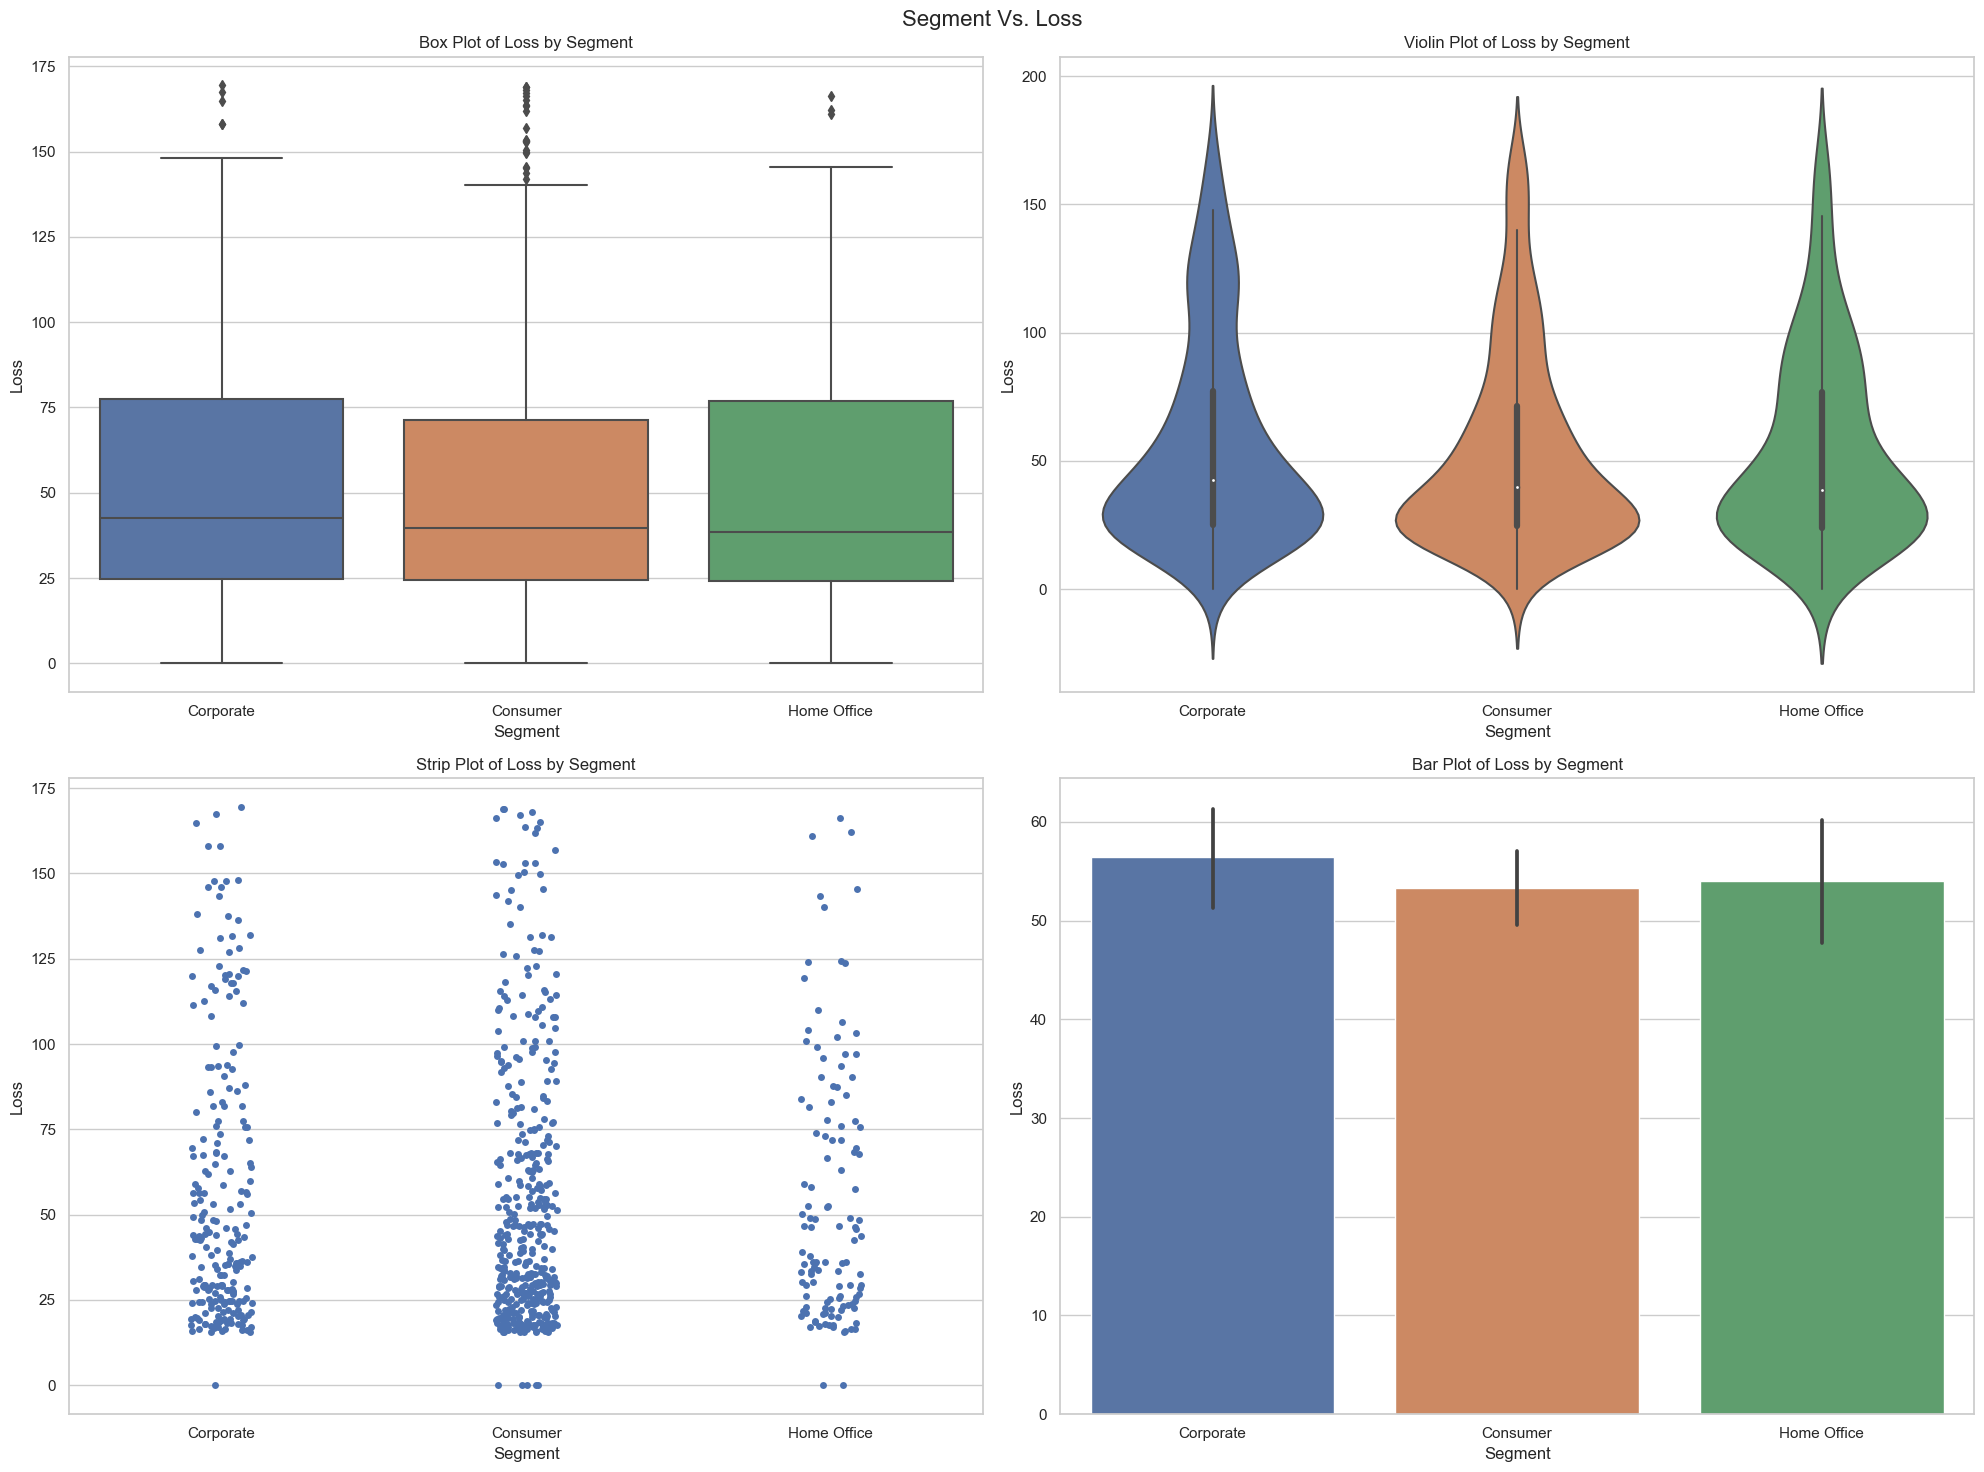

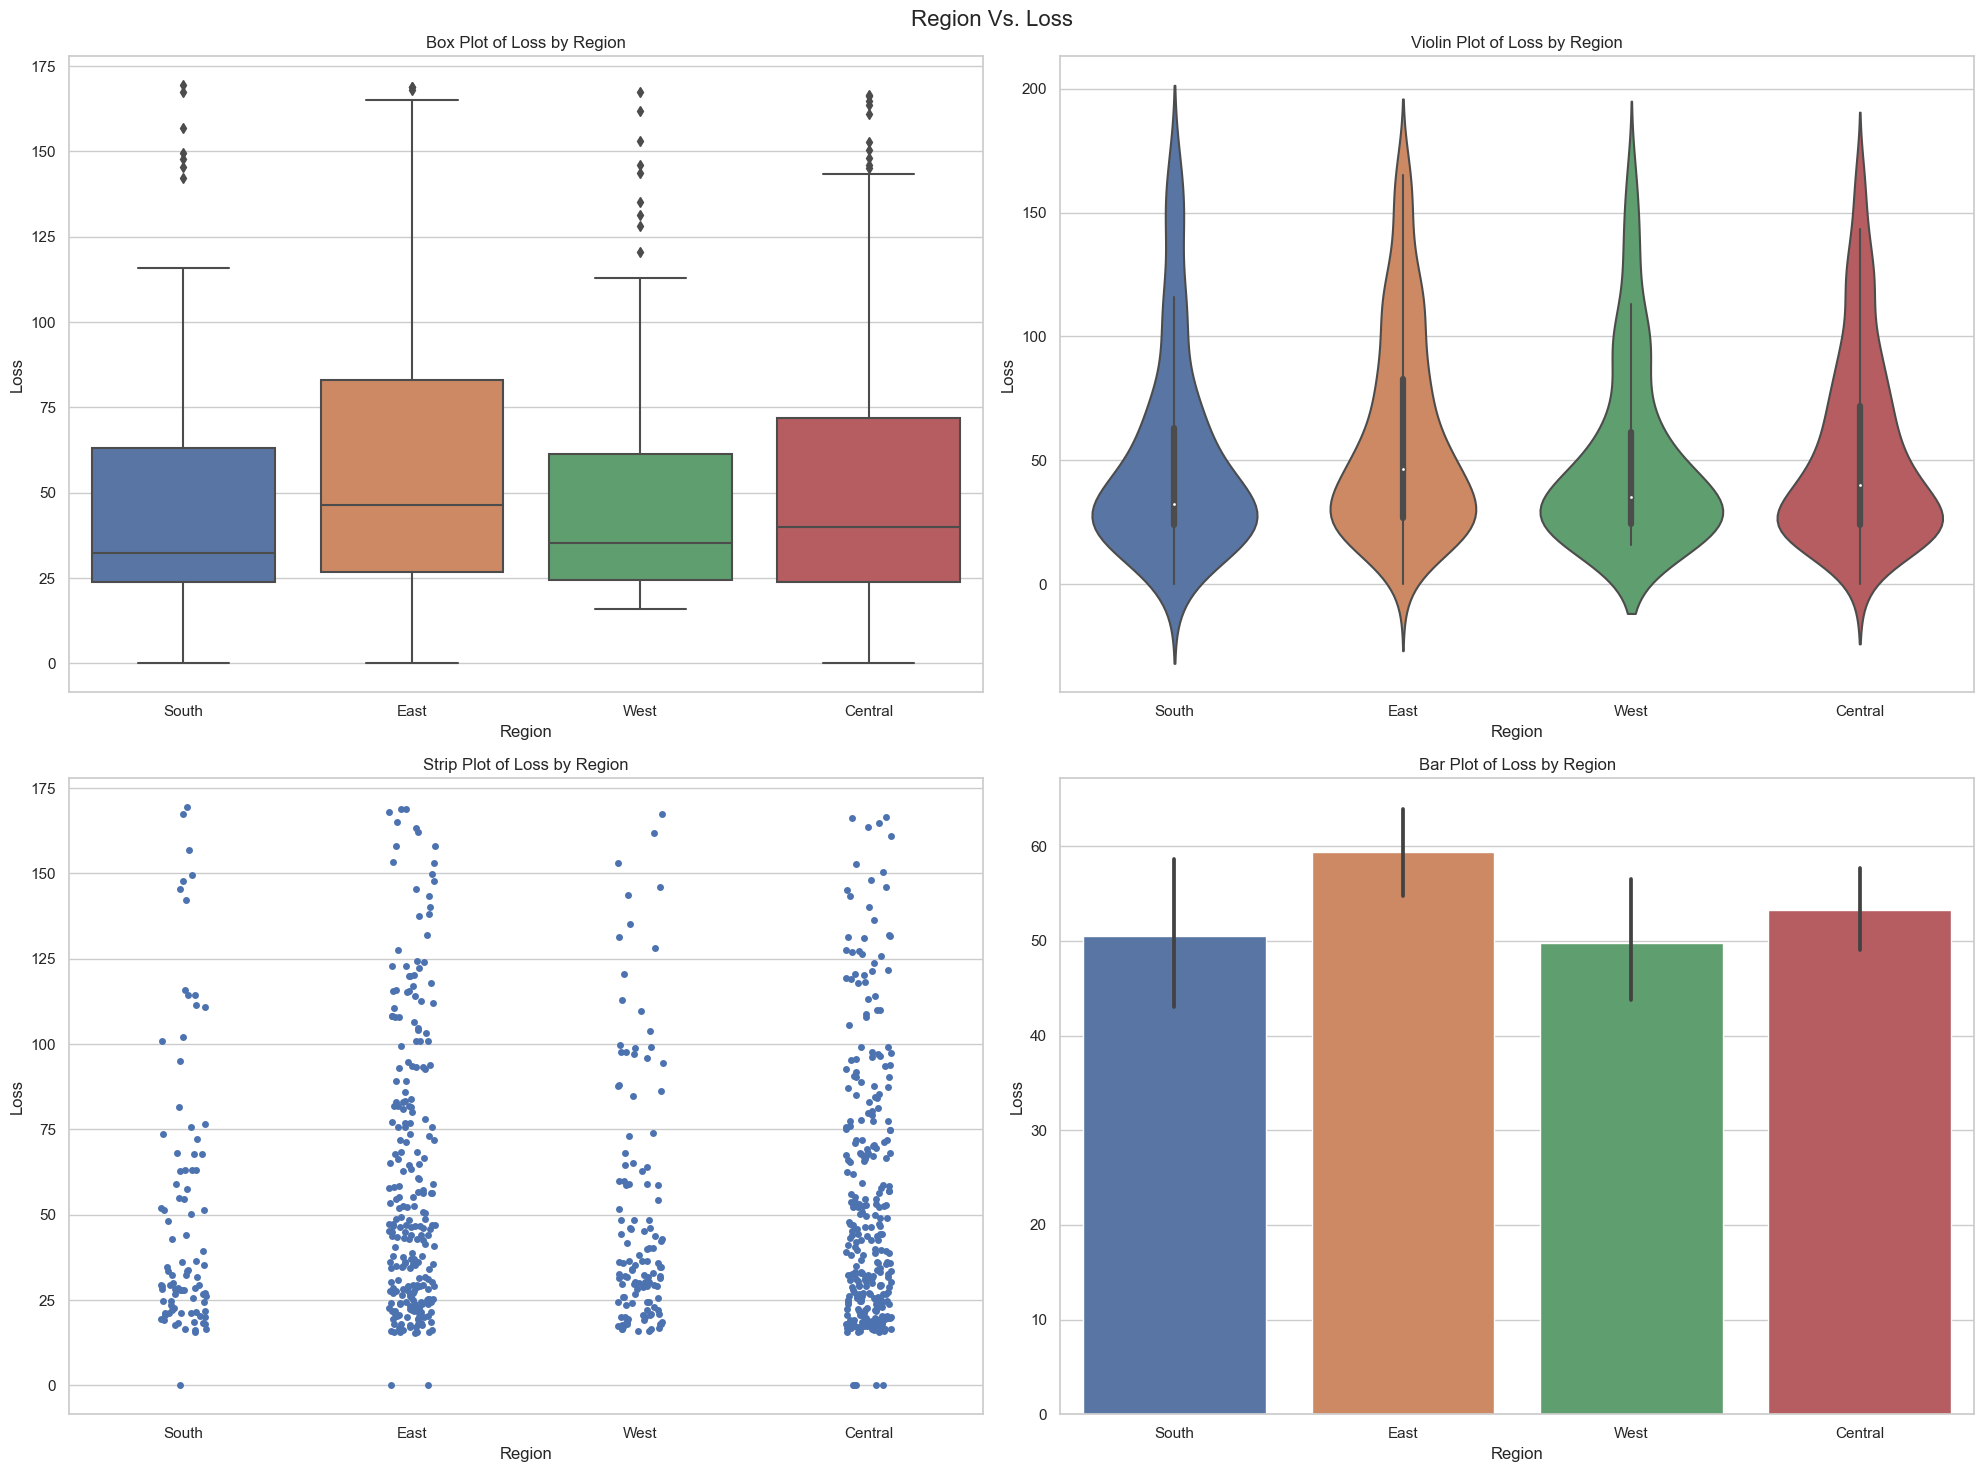

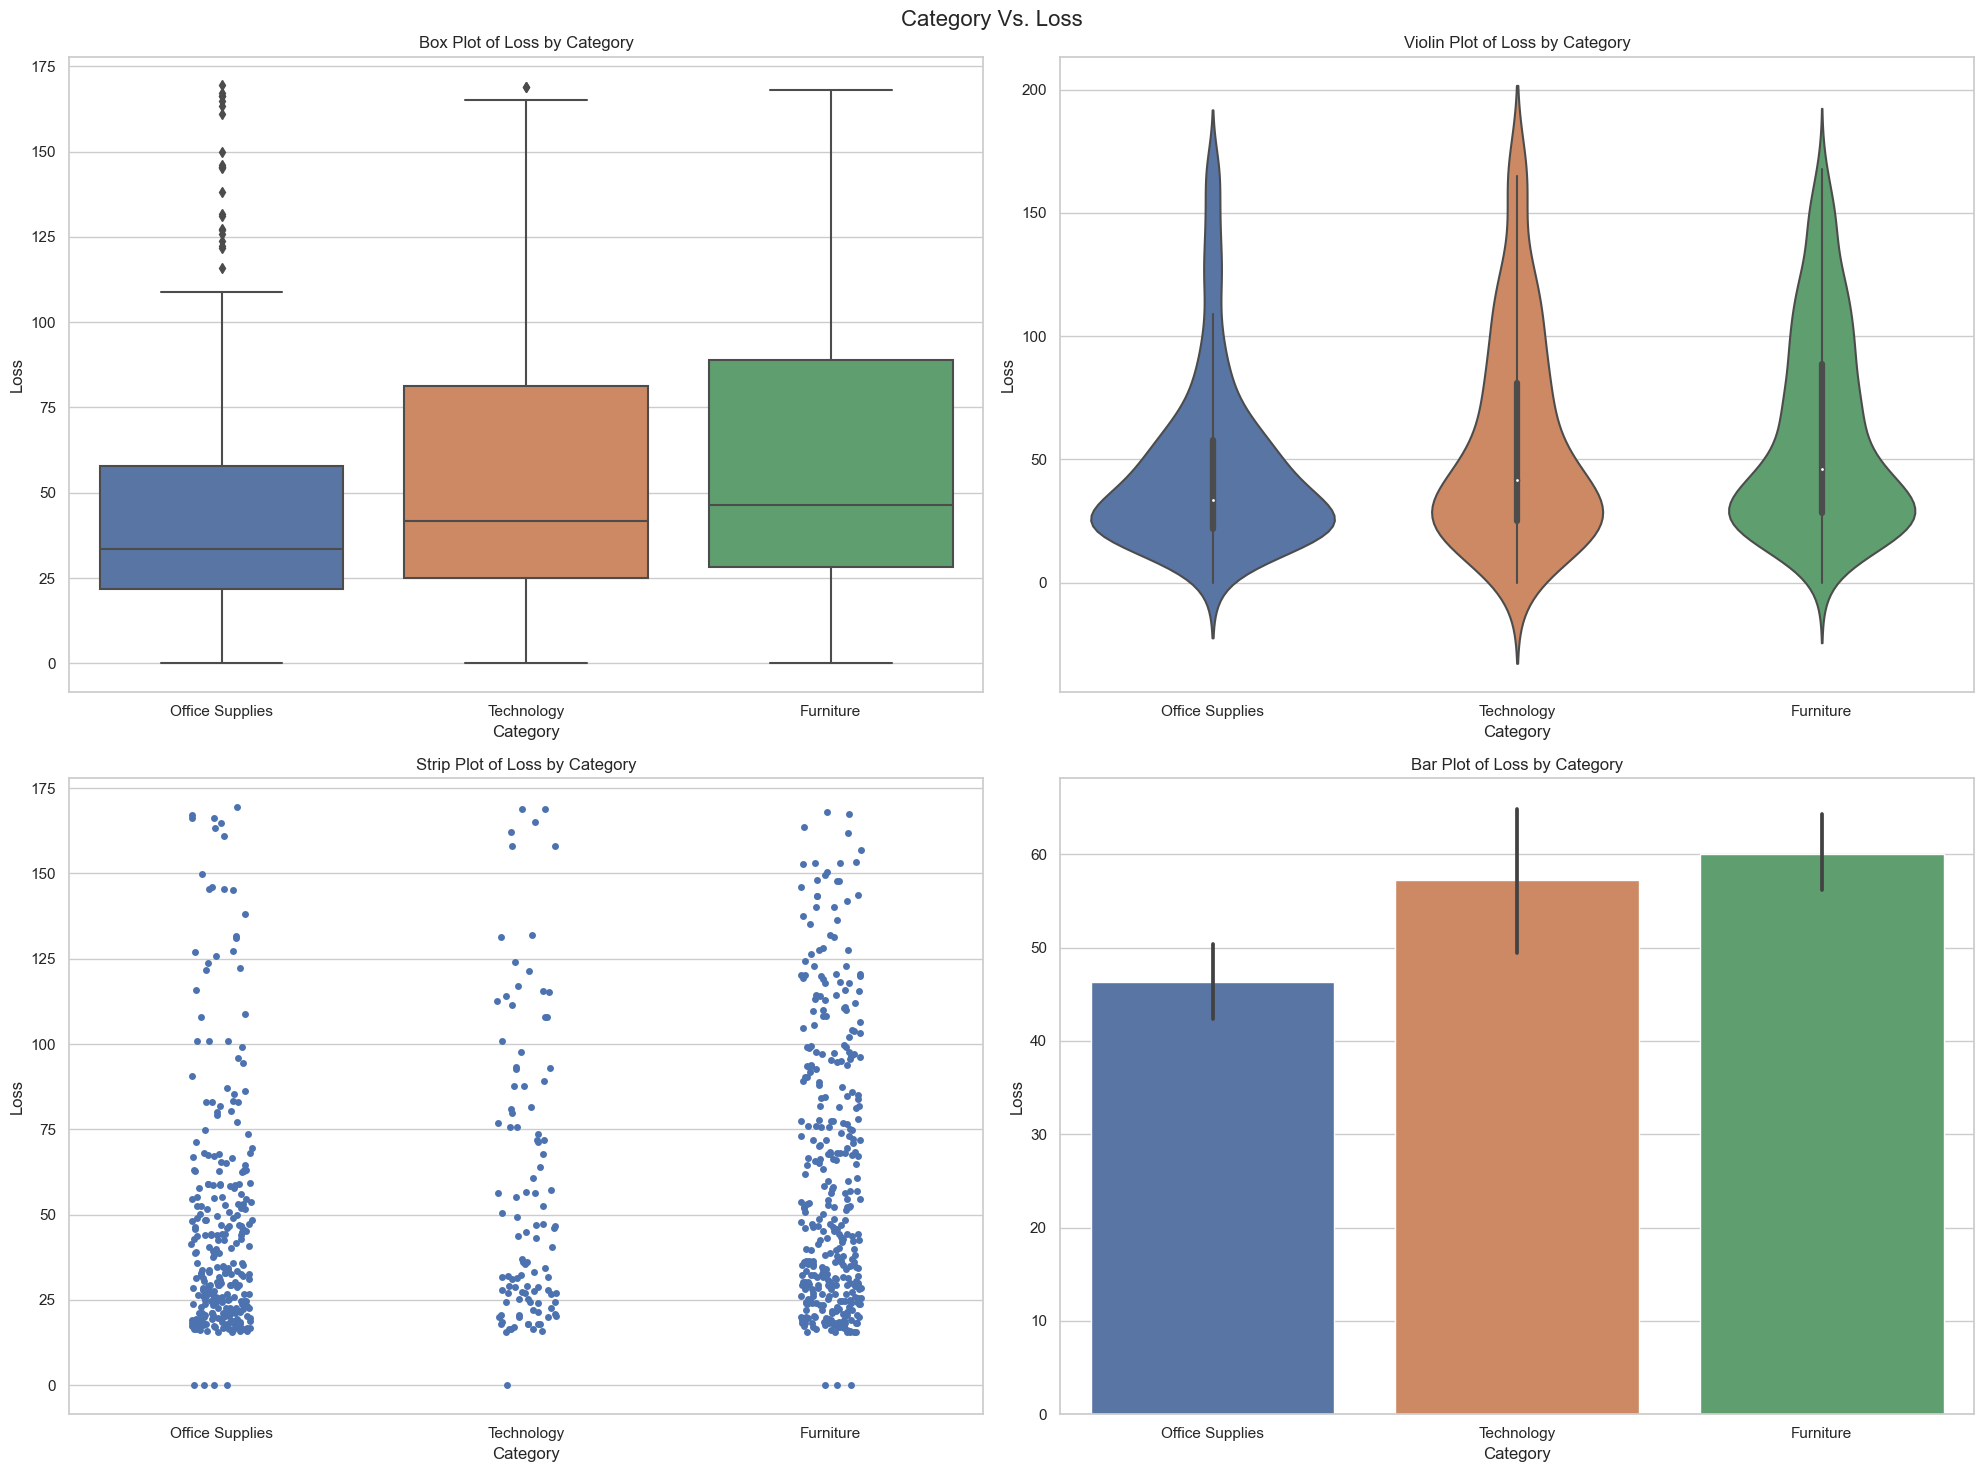

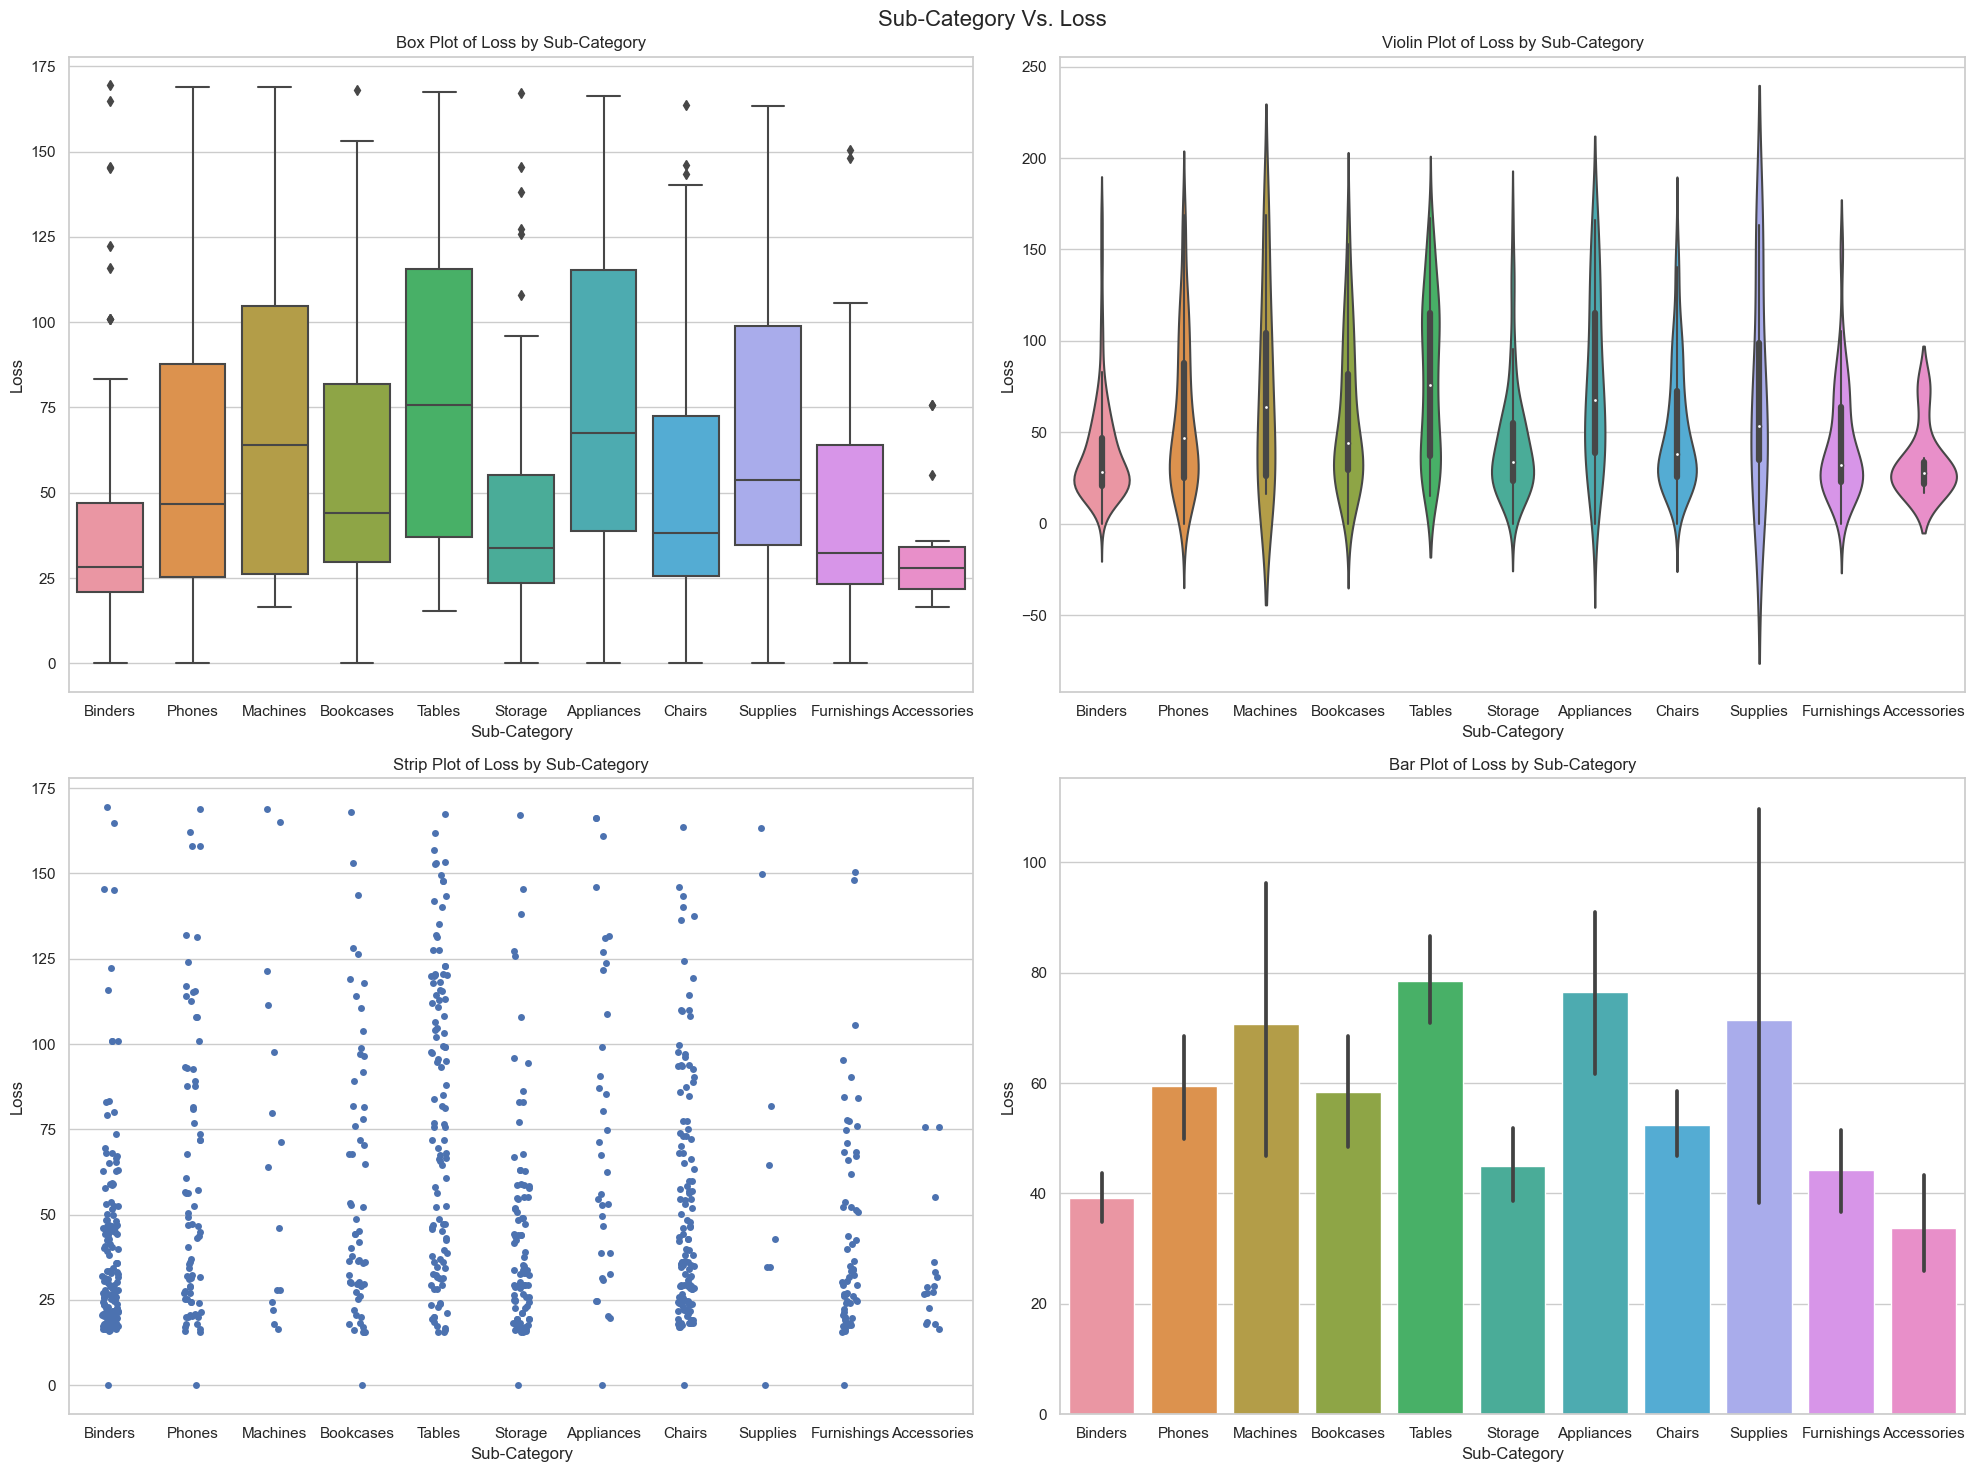

In [1555]:
bivariate_analysis_categorical_numerical(global_super_store_df, 'Segment', 'Loss')
bivariate_analysis_categorical_numerical(global_super_store_df, 'Region', 'Loss')
bivariate_analysis_categorical_numerical(global_super_store_df, 'Category', 'Loss')
bivariate_analysis_categorical_numerical(global_super_store_df, 'Sub-Category', 'Loss')

#### Categories Vs. Quantity

In [ ]:
bivariate_analysis_categorical_numerical(global_super_store_df, 'Segment', 'Quantity')
bivariate_analysis_categorical_numerical(global_super_store_df, 'Region', 'Quantity')
bivariate_analysis_categorical_numerical(global_super_store_df, 'Category', 'Quantity')
bivariate_analysis_categorical_numerical(global_super_store_df, 'Sub-Category', 'Quantity')

#### Geo Analysis

In [ ]:
def geo_analysis_by_state(df, feature_column):
    """
    geo_analysis_by_state, plots the feature percentages on a US map grouped by States

    Args:
    - df (DataFrame): DataFrame containing the feature data.
    - feature_column (str): Name of the numerical feature column.

    Returns:
    - None
    """
    
    base_folder_path = os.getcwd()
    shp_path = '/data/usa-states-census-2014.shp'

    us_states = gpd.read_file(f'{base_folder_path}{shp_path}')
    us_states = us_states.to_crs("EPSG:3395")

    # Group feature data based on States
    feature_per_states = df.groupby(['State'], as_index=False)[[feature_column]].sum()

    # Create a new column to see the Feature %
    feature_percent_column_name = feature_column + ' %'

    # Calculate the sum of the feature_column
    total_feature_sum = df[feature_column].sum()

    # Check if the total sum is zero
    if total_feature_sum == 0:
        # If the total sum is zero, set all percentages to zero or handle the scenario according to your specific requirements
        feature_per_states[feature_percent_column_name] = 0
    else:
        # Calculate percentages only if the total sum is not zero
        feature_per_states[feature_percent_column_name] = (feature_per_states[feature_column] / total_feature_sum) * 100

    # Merge sales data with the US map based on state codes or names
    merged_data = us_states.merge(feature_per_states, how='left', left_on='NAME', right_on='State')

    # Filter out duplicate entries
    merged_data = merged_data.drop_duplicates(subset=['NAME'])

    # Fill NaN values with 0 for the percentage column
    merged_data[feature_percent_column_name].fillna(0, inplace=True)

    # Plot the map
    fig, ax = plt.subplots(1, 1, figsize=(30, 10))
    us_states.plot(ax=ax, color='lightgrey', edgecolor='black')
    merged_data.plot(column=feature_percent_column_name, cmap='Spectral_r', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True, aspect='equal')

    # Annotate state names and sales percentages
    texts = []
    for idx, row in merged_data.iterrows():
        x = row['geometry'].centroid.x
        y = row['geometry'].centroid.y
        name = row['NAME']
        feature_percent = row[feature_percent_column_name]
        text = ax.text(x, y, name, fontsize=9, ha='center', va='center', color='black')
        texts.append(text)
        text = ax.text(x, y-0.5, f"{feature_percent:.2f}%", fontsize=9, ha='center', va='center', color='black')  # Adjust y position
        texts.append(text)

    # Adjust text labels to avoid overlaps
    adjust_text(texts, arrowprops=dict(arrowstyle='-', color='grey'))

    ax.axis('off')
    ax.set_title(f'{feature_column} percent by US State', loc='center', fontsize=20, y=1.0)
    plt.show()

##### Sales % based on US States

In [ ]:
geo_analysis_by_state(global_super_store_df, 'Sales')

##### Quantity % based on US States

In [ ]:
geo_analysis_by_state(global_super_store_df, 'Quantity')

##### Loss % based on US States

In [ ]:
geo_analysis_by_state(global_super_store_df, 'Loss')

##### Discount % based on US States

In [ ]:
geo_analysis_by_state(global_super_store_df, 'Discount')

* Sales conclusion:
    * **Texas** has the most percentage of Sales with ~23%.
    * The Central and South regions of the country collectively could not match the sales numbers of Texas.

* Quantity conclusion:
    * **Texas** sold ~28% of products.

* Losses conclusion:
    * **Texas** despite of making ~23% of Sales, has grossed an ~26% of losses.

### Conculsion

* Categorical Vs. Categorical Conclusion
    * Chi-square test of independence pointed us that the following categories has a significant association:
        * *Category* Vs. *Sub-Category*
        * *Region* Vs. *Category*
        * *Region* Vs. *Sub-Category*
    * Function `categorical_analysis` plotted cross-tabulation and stacked bar plot on the choose categories. Then `bivariate_categorical_figure_analysis` function would plot the pivot-table and heatmaps to given categorical features. In summary:
        * *Category* Vs. *Sub-Category*
            * Binders Sub-Category appeared on most number of Sales, close next is Chairs.
            * But Chairs has the highest sales value, followed by Tables.
            * Binders, and Chairs made almost the same value of loss.
        * *Region* Vs. *Category*
            * Central Region has made highest number of sales on Furniture Category, second close is Office Supplies Category, also from Central Region.
            * Same goes to the sales values, Central Region made the highest sales on Furniture, followed by Furniture category in the East Region.
            * Furniture from Central Region marks the highest loss as well. 
        * *Region* Vs. *Sub-Category*
            * Binders Sub-Category on Central Region appeared on most number of Sales, close next is Phones on East Region.
            * But Chairs from Central Region has the highest sales value, followed by Phones on East Region.
            * Tables from East Region marks the highest loss, close second will be Phones on East Region. 


* Numerical Vs. Numerical Conclusion
    * Sales and Discount correlation of -0.58
        * Indicates a moderate negative relationship between sales and discounts.
        * Meaning that when discounts increase, sales tend to decrease, and vice versa.
        * Since it is a moderate negative relationship, does not imply causation.
    * Sales and Loss correlation of 0.40
        * Indicates a moderate positive relationship between sales and loss.
        * Meaning that when sales increase, loss tend to increase, and vice versa.
        * Since it is a moderate positive relationship, does not imply causation.
    * The other numerical variable has either a weak positive/negative relationship, we cannot take fruitful decisions, especially causation.


* Categorical Vs. Numerical Conclusion
    * Consumer Segment has ~56% of the sales value, but Corporate Segment has the highest loss percentages.
    * Eastern Region is responsible for ~37% of the sales, most of it coming from Texas. Central Region marks the highest loss percentage.
    * Furniture Category has the highest percentage of sales with ~53% and also the losses at ~39%.
    * Appliance Sub-category made the highest loss at 241.38%.